## Logistic Regression Notebook

Continuing on form the linear regression notebook, in this notebook I am going to build a logistic regression model and compare it to scikit learn's own model, using Python's in built matrix features in numpy.

I have based the theory of this notebook on this useful website: https://www.statlect.com/fundamentals-of-statistics/logistic-model-maximum-likelihood

Again, I'm going to do this using the well known Iris dataset.

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from sklearn.datasets import load_iris
df = load_iris(as_frame=True)
df.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [2]:
df.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

We are going to only look at the binomial case and argue that either a flower is a versicolor or not. In the target this is 1, hence we set this to 1 and the other species to 0.

In [3]:
y = (df.target == 1) * 1

Logistic regression takes form:

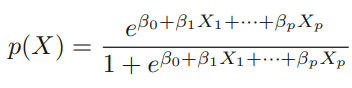where P(X) is the probaility that the x belongs to the category, i.e. is a setosa flower. More intuitively we can think about this equation as the logit of P(X):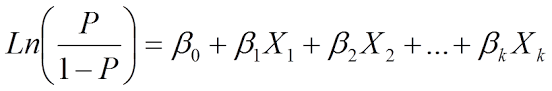
In order to calculate our estimates for the Beta coefficients, based on the data, we need to minimise the Maximum Likelihood Estimator:

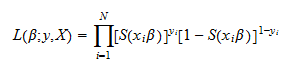Where: 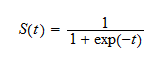 Taking the log-likelihood we get: 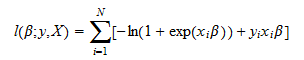

This has no explicit solution, hence we use the Newtan-Raphson approach to iteratively reduce the equation: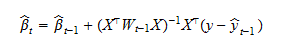 Where: 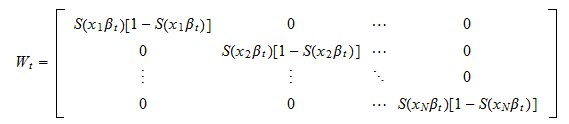

We need to start with a Beta vector of length 5, one of each variable and Beta0, initially we will assume all 0s, but may need to change if it does not converge.

In [4]:
Beta0 = np.zeros(5)

Next let's define X and XT, which are just the independent variables. Note we need to add a column of 1s to match Beta0.

In [5]:
b0 = pd.Series(np.ones(150))
df.data["b0"] = b0
X = df.data.values

Next we will define W0 and the sigmoid of X and Beta0.

In [6]:
S_X_Beta0 = 1 / (1 + np.exp(- np.matmul(X, Beta0)))
W0 = S_X_Beta0 * (1 - S_X_Beta0)
W0 = np.diag(W0)

Finally, we need to define y and y hat 0. y will just be our target variable, y hat 0 will be the prediction using Beta0: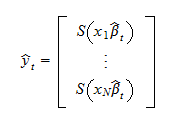

In [8]:
y_hat_0 = S_X_Beta0

Now let's define a function that will run the recursive formula:

In [9]:
def newton_raphson(W_t, X, y, y_hat_t, beta_t):
    hessian = np.matmul(X.transpose(), np.matmul(W_t, X))
    hessian_inv = np.linalg.inv(hessian)
    mat = np.matmul(np.matmul(hessian_inv, X.transpose()),(y - y_hat_t))
    return beta_t + mat

Before we attempt to derive the parameters, it is important to define a cost function in order to know when an appropriate number of iterations of Newton-Raphson are. The cost function is the negative of the log-likelihood / the number of obsevations. First, we define the log-likelihood function:

In [10]:
def Z(Xi, beta):
    return np.matmul(Xi, beta)

def log_likelihood(beta):
    l = 0
    for i in range(len(y)):
        l += (-np.log(1 + np.exp(Z(X[i,:], beta))) + y[i]*Z(X[i,:], beta))
    return l

In turn we define the cost function:

In [11]:
def cost(beta):
    return - log_likelihood(beta) / 150

Then we set the starting points for the recursive elements to enter into the recursion. We set a try except statement to run until we get a linear algebra error (i.e. the hessian is singular and cannot invert). We record the cost function difference between iterations and number the of epochs, and cancel the loop once the cost difference for each iteration is very small.

In [12]:
beta_t = Beta0
W_t = W0
y_hat_t = y_hat_0
epoch = 0
cost_diff = 1

while cost_diff > 0.00001:
    cost_t = cost(beta=beta_t)
    try:
        beta_t = newton_raphson(W_t, X, y, y_hat_t, beta_t)
        epoch += 1
    except LinAlgError:
        cost_diff = 0
        print("Singular matrix encountered, iterations ended.")
    finally:
        S_X_Beta_t = 1 / (1 + np.exp(- np.matmul(X, beta_t)))
        S_X_Beta_t = S_X_Beta_t
        W_t = S_X_Beta_t * (1 - S_X_Beta_t)
        W_t = np.diag(W_t)
        y_hat_t = S_X_Beta_t
        cost_t1 = cost(beta=beta_t)
        cost_diff = abs(cost_t1 - cost_t)
    
print(epoch)
print(cost_diff)
beta_t

4
3.8089796956519706e-06


array([-0.24534567, -2.79649186,  1.31361824, -2.77830515,  7.37826243])

I thought it would also be interesting to attempt to derive the parameters using SciPy's optimization tool, which has many different methods for deriving the parameters. We will use the 'L-BFGS-B' method here since this is what sklearn uses in their logistic regression package. Note here I will minimize the cost function as this is equivalent to maximizing the log-likelihood.

In [13]:
from scipy import optimize

optimize.minimize(cost, [0,0,0,0,0], method='L-BFGS-B')

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.4835655827655022
        x: [-2.454e-01 -2.797e+00  1.314e+00 -2.778e+00  7.378e+00]
      nit: 39
      jac: [ 1.129e-05  1.876e-06  1.585e-05  5.684e-06  9.659e-07]
     nfev: 270
     njev: 45
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

We see that we optain the same parameters, however, it takes 39 iterations whereas the Newton-Raphson only took 4. The L-BGFS-B method is a 'quasi-Newton' method as it does not take the inverse of the Hessian, but approximates it, and hence does not run into the issue if the Hessian is singular.

Now let's compare our results to sklearn. Note that we set penalty to None here to replciate our method above, however, in a realistic model we would probably want some sort of regularization to punish overly large parameters, which would be a result of over-fitting the data.

In [15]:
X_train = df.data.values[:,:4]

from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(penalty=None)
logmodel.fit(X_train,y)

print(logmodel.coef_)
print(logmodel.intercept_)

[[-0.24535745 -2.79656276  1.31365383 -2.77836927]]
[7.37846558]


We can see that once again we get the same parameters. Finally let's have a quick look at how our model performs.

In [19]:
predict = logmodel.predict(X_train)

from sklearn.metrics import classification_report, confusion_matrix
cmat = confusion_matrix(y,predict)
cmat = np.array([[f"TP: {cmat[0,0]}",f"FN: {cmat[0,1]}"],[f"FP: {cmat[1,0]}",f"TN: {cmat[1,1]}"]])
cm_df = pd.DataFrame(cmat, index=["actual positive", "actual negative"], columns=["predicted postive", "predicted negative"])
print(classification_report(y,predict))
print(f"Confusion matrix: \n{cm_df}")

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.64      0.50      0.56        50

    accuracy                           0.74       150
   macro avg       0.71      0.68      0.69       150
weighted avg       0.73      0.74      0.73       150

Confusion matrix: 
                predicted postive predicted negative
actual positive            TP: 86             FN: 14
actual negative            FP: 25             TN: 25


Note, we have tested the data on the training dataset, which will obviously not give us a an accurate idea of the models actual performance, but for these purposes we can note that the model fits the data reasonably well with an accuracy of 74%.